## DeepWalk

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
import warnings
import os

warnings.filterwarnings('ignore')
data_path = os.environ.get('DATA_PATH') + 'AI_Cheats/'


In [3]:
G = nx.read_gml(data_path + 'football/football.gml')

In [4]:
print("Length: \n", len(G))
print("Node: \n", G.nodes())
print("Edges: \n", G.edges())

Length: 
 115
Node: 
 ['BrighamYoung', 'FloridaState', 'Iowa', 'KansasState', 'NewMexico', 'TexasTech', 'PennState', 'SouthernCalifornia', 'ArizonaState', 'SanDiegoState', 'Baylor', 'NorthTexas', 'NorthernIllinois', 'Northwestern', 'WesternMichigan', 'Wisconsin', 'Wyoming', 'Auburn', 'Akron', 'VirginiaTech', 'Alabama', 'UCLA', 'Arizona', 'Utah', 'ArkansasState', 'NorthCarolinaState', 'BallState', 'Florida', 'BoiseState', 'BostonCollege', 'WestVirginia', 'BowlingGreenState', 'Michigan', 'Virginia', 'Buffalo', 'Syracuse', 'CentralFlorida', 'GeorgiaTech', 'CentralMichigan', 'Purdue', 'Colorado', 'ColoradoState', 'Connecticut', 'EasternMichigan', 'EastCarolina', 'Duke', 'FresnoState', 'OhioState', 'Houston', 'Rice', 'Idaho', 'Washington', 'Kansas', 'SouthernMethodist', 'Kent', 'Pittsburgh', 'Kentucky', 'Louisville', 'LouisianaTech', 'LouisianaMonroe', 'Minnesota', 'MiamiOhio', 'Vanderbilt', 'MiddleTennesseeState', 'Illinois', 'MississippiState', 'Memphis', 'Nevada', 'Oregon', 'NewMexicoSta

In [5]:
def get_randomwalk(node, path_length):
  random_walk = [node]
  for i in range(path_length-1):
    temp = list(G.neighbors(node))
    temp = list(set(temp) - set(random_walk))
    if len(temp) == 0:
      break
    random_node = random.choice(temp)
    random_walk.append(random_node)
    node = random_node
  return random_walk
print(get_randomwalk('EastCarolina', 10))

['EastCarolina', 'Army', 'BostonCollege', 'Connecticut', 'Louisville', 'Tulane', 'SouthernMethodist', 'TexasElPaso', 'NewMexicoState', 'UtahState']


In [6]:
all_nodes = list(G.nodes())

In [7]:
random_walks = []
for n in tqdm(all_nodes):
	# 每个节点游走 5 次，每次最长距离为 10
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))

100%|██████████| 115/115 [00:00<00:00, 14993.63it/s]


In [8]:
print('Node: \n', random_walks)
print('Length: \n', len(random_walks))

Node: 
 [['BrighamYoung', 'ColoradoState', 'Utah', 'NevadaLasVegas', 'NewMexico', 'AirForce', 'SanDiegoState', 'ArizonaState', 'Washington', 'MiamiFlorida'], ['BrighamYoung', 'Virginia', 'NorthCarolina', 'Clemson', 'WakeForest', 'GeorgiaTech', 'Duke', 'Northwestern', 'Minnesota', 'Ohio'], ['BrighamYoung', 'SanDiegoState', 'Illinois', 'PennState', 'MichiganState', 'NotreDame', 'SouthernCalifornia', 'SanJoseState', 'SouthernMethodist', 'Tulsa'], ['BrighamYoung', 'NewMexico', 'SanDiegoState', 'ArizonaState', 'Washington', 'WashingtonState', 'Oregon', 'SouthernCalifornia', 'NotreDame', 'TexasA&M'], ['BrighamYoung', 'Utah', 'AirForce', 'ColoradoState', 'NevadaLasVegas', 'IowaState', 'Kansas', 'TexasTech', 'KansasState', 'NorthTexas'], ['FloridaState', 'MiamiFlorida', 'Pittsburgh', 'NorthCarolina', 'Maryland', 'WestVirginia', 'NotreDame', 'TexasA&M', 'OklahomaState', 'SouthernMississippi'], ['FloridaState', 'Duke', 'Northwestern', 'Iowa', 'Indiana', 'Purdue', 'Kent', 'WesternMichigan', 'Cent

In [9]:
# 训练 skip-gram (word2vec)模型
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # 负采样
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)
# 从 random_walks 中创建词汇表
model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
print(model)
# 输出和 EastCarolina 相似的球队
print(model.wv.similar_by_word('EastCarolina'))

Word2Vec<vocab=115, vector_size=100, alpha=0.03>
[('Louisville', 0.972120463848114), ('Army', 0.9575409889221191), ('Cincinnati', 0.938748300075531), ('SouthernMississippi', 0.9278153777122498), ('Tulane', 0.9218607544898987), ('Houston', 0.9021687507629395), ('Memphis', 0.8919076919555664), ('AlabamaBirmingham', 0.8807187080383301), ('Navy', 0.8782751560211182), ('VirginiaTech', 0.8299756646156311)]


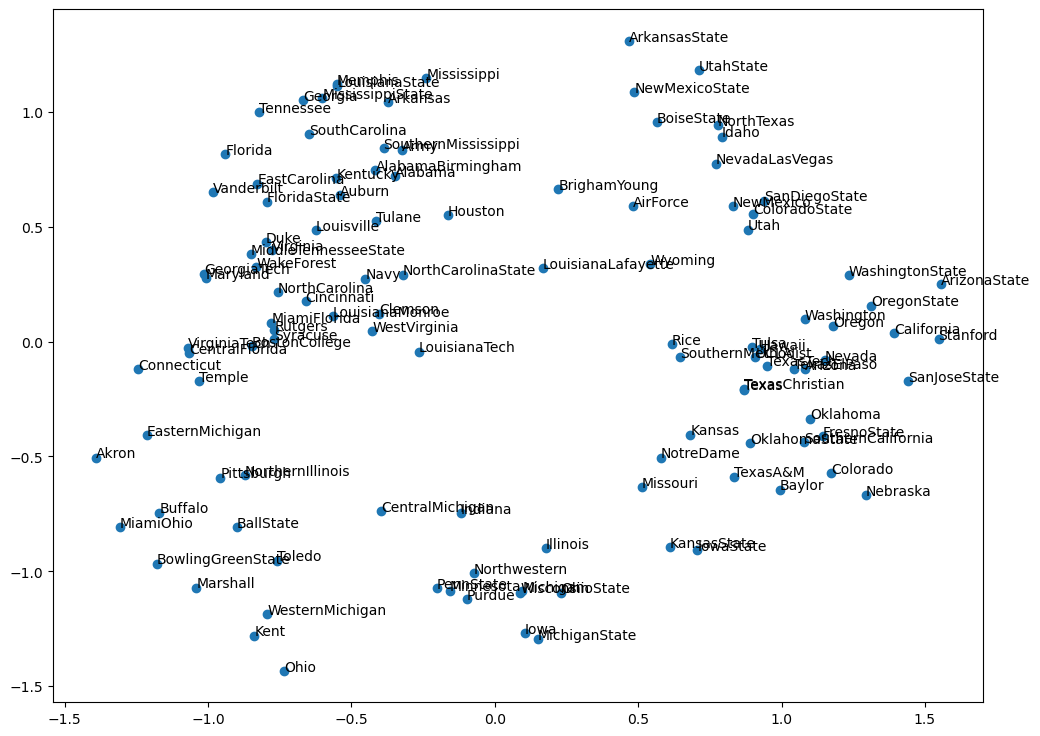

In [11]:
plt.rcParams.update(plt.rcParamsDefault)
# 在二维空间中绘制所选节点的向量
def plot_nodes(word_list):
	# 每个节点的 embedding 为 100 维
    X = model.wv[word_list]
    #print(type(X))
    # 将 100 维向量减少到 2 维
    pca = PCA(n_components=2)
    result = pca.fit_transform(X) 
    #print(result)
    # 绘制节点向量
    plt.figure(figsize=(12,9))
    # 创建一个散点图的投影
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))        
    plt.show()
    
# 将所有的球队 embedding 进行绘制
word_list = list(model.wv.key_to_index.keys())
plot_nodes(word_list)